# Highway over protected areas

We can already work with single polygon geometry data source containing [protected areas](data/protected_areas.gpkg). Let's import linear data with [highways](data/highways.geojson). Highways are stored in the GeoJSON format 

In [1]:
import fiona
from shapely.geometry import mapping, shape

pas = fiona.open("data/protected_areas.gpkg", "r")
hws = fiona.open("data/highways.geojson", "r")

<img src="images/qgis_result.png" width="600" />

## Converting geometries to different coordinate reference system

GeoJSON data should be, by definition, in WGS84 ([EPSG:4326](http://epsg.io/4326)) coordinate reference system. That means, the data are between -180, 180 and -90, 90 degrees.

In [2]:
hws[0]["geometry"]

We have to transform the data to meters and to the same projection how our `protected_areas` are stored. For this we need to define an object with the source coordinate reference system and another object with the target coordinate reference system. This can be done in `fiona.transform` module.

In [3]:
from fiona.transform import transform_geom

wgs84 = "EPSG:4326"
etrs89 = pas.crs

Let's make 100m buffer around each highway

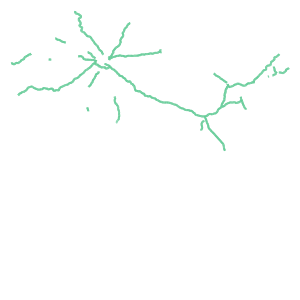

In [4]:
from shapely.geometry import MultiLineString

all_highways = []

for hw in hws:
    geom_transformed = transform_geom(wgs84, etrs89, hw["geometry"])
    geom = shape(geom_transformed)
    all_highways.append(geom)
    
MultiLineString(all_highways)

Tramsform geometires, but only for the new planed `D8` highway

<img src="images/highway_8.png" width="400" />

In [5]:
buffered_highways = {}

for hw in hws:
    
    # but only new planed highway over Czech Central Mountains
    if hw["properties"]["ref"] == "D8":
        geom_transformed = transform_geom(wgs84, etrs89, hw["geometry"])
    
        geom = shape(geom_transformed)

        buffered_highways[hw["id"]] = geom.buffer(100)

Some visualisation of the data - we will convert multiple geometries into one `Multi` geometry. We also use `simplify` method, which will [simplify geometires using Douglas-Peucker algorithm](http://toblerity.org/shapely/manual.html#object.simplify).

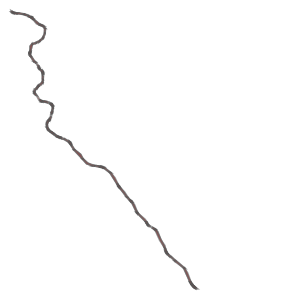

In [6]:
from shapely.geometry import MultiPolygon, MultiLineString

MultiPolygon(
    buffered_highways[g].simplify(200, preserve_topology=False) 
    for g in buffered_highways
)

We do same visualisation with our `protected_areas`:

In [7]:
protected_areas = {}

for pa in pas:
    geom = shape(pa["geometry"])
    protected_areas[pa["id"]] = geom
    
MultiPolygon(protected_areas[g].simplify(1000, preserve_topology=False) for g in protected_areas)

TypeError: 'MultiPolygon' object is not subscriptable

Now let's find out, which highways with 100m buffer around the line do intersect with geometries of protected areas

In [ ]:
from shapely import speedups
print(speedups.available)
speedups.enable()

In [ ]:
intersections = []

for i in buffered_highways:
    hw = buffered_highways[i]
    
    for j in protected_areas:
        pa = protected_areas[j]
        
        if hw.intersects(pa) and j not in intersections:
            intersections.append(j)

In [ ]:
MultiPolygon([protected_areas[i].simplify(10) for i in intersections] + [buffered_highways[j] for j in buffered_highways] )

In [ ]:
print(len(intersections))

Let's create output GeoJSON-encoded file with resulting areas:

In [ ]:
import json

data = {"type": "FeatureCollection", "features":[]}
filtered_pas = list(filter(lambda x: x["id"] in intersections, pas))
for pa in filtered_pas:
    pa["geometry"] = transform_geom(etrs89, wgs84, pa["geometry"])
    data["features"].append(pa)

with open("../outputs/crossing_areas.geojson", "w") as out:
    json.dump(data, out)



[Download the crossing areas file](../outputs/crossing_areas.geojson) and open it in [QGIS](http://qgis.org)

<img src="images/result.png" width="400" />


Getting just the affected area

In [ ]:
intersections = []

for i in buffered_highways:
    hw = buffered_highways[i]
    
    for j in protected_areas:
        pa = protected_areas[j]
        
        if hw.intersects(pa):
            out_geom = hw.intersection(pa)
            intersections.append(out_geom)
MultiPolygon([geom.simplify(10) for geom in intersections])

---
[<- Working with vector geometries](04_geometries.ipynb) | [Introduction to rasters ->](../02_rasters/00_introduction.ipynb)